In [1]:
%matplotlib inline

In [2]:
import astropy.units as u
import celerite
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np

from astropy.units import cds
from celerite import terms

cds.enable()

In [3]:
import astropy.units as u
import celerite
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np

from astropy.units import cds
from celerite import terms

cds.enable()

class AsteroTerm(terms.SHOTerm):

    parameter_names = (
        "height", "freq", "lwd",
    )

    def __init__(self, *args, **kwargs):
        super(AsteroTerm, self).__init__(*args, **kwargs)

    #def get_complex_coefficients(self, params):
    #    (log_S, log_omega, log_Q) = params
    #    
    #    a = np.exp(log_S + log_omega + log_Q)
    #    b = a / np.sqrt(4*np.exp(2*log_Q) - 1)
    #    c = np.exp(log_omega) / (2 * np.exp(log_Q))
    #    d = c * np.sqrt(4*np.exp(2*log_Q) - 1)
    #    return (
    #        a,
    #        b,
    #        c,
    #        d
    #    )

    def get_all_coefficients(self, params):

        # Convert to cycles per day
        nu0_cpd = params[1] * (86400.0 / 1e6)
        lwd_cpd = params[2] * (86400.0 / 1e6)
        height_cpd = params[0] * (1e6/86400.0)

        # Account for normalisation in height
        height = height_cpd * np.sqrt(np.pi/2) / 4
        # 
        omega0 = 2 * np.pi * nu0_cpd 
        Q = nu0_cpd / lwd_cpd

        #
        coeffs = []
        for i in range(1):
            log_S0 = np.log(height) - 2*np.log(Q)
            log_Q = np.log(Q)
            log_omega0 = np.log(omega0)
            coeffs.append(super(AsteroTerm, self).get_all_coefficients([log_S0, log_Q, log_omega0]))
        return [np.concatenate(args) for args in zip(*coeffs)]

    #def get_terms(self):
    #    coeffs = self.get_complex_coefficients()
    #    return [terms.ComplexTerm(*(np.log(args))) for args in zip(*coeffs)]

def compute_mode(params, white=0):
    """
    doc-string needed
    """

    #if white == 0:
    #    white = 1e-12


    #print(f"S0: {S0}")

    # Convert parameters to cycles per day
    lwd = params[2] * (86400.0 / 1e6)
    nu0 = params[1] * (86400.0 / 1e6)
    height = params[0] * (86400.0/1e6)

    Q = (2 * np.pi * nu0) / (2 * np.pi * lwd)
    omega = 2 * np.pi * nu0
    S0 = height * (lwd/nu0)**2 * 4 * np.sqrt(2/np.pi)

    kernel = AsteroTerm(height=params[0],
                        freq = params[1],
                        lwd = params[2])
    kernel += terms.JitterTerm(log_sigma = np.log(white))

    gp = celerite.GP(kernel)
    return kernel, gp, S0

def compute_lor_model(f, params, dt, white=0):

    # dt must be in seconds!
    backg = 2e-6 * white**2 * dt

    model = np.ones_like(f) * backg
    
    x = (2 / params[2]) * (f - params[1])
    model += (params[0] / (1 + x**2))

    return model

def compute_full_model(f, params, dt, white=0):

    # Convert parameters to cycles per day
    lwd = params[2] * (86400.0 / 1e6)
    nu0 = params[1] * (86400.0 / 1e6)
    height = params[0]# * (1e6/86400.0)

    Q = (2 * np.pi * nu0) / (2 * np.pi * lwd)
    omega0 = 2 * np.pi * nu0
    omega = 2 * np.pi * f * (86400.0 / 1e6)
    S0 = height * (lwd/nu0)**2# * 4 * np.sqrt(2/np.pi)

    H = S0*omega0**4
    x0 = (omega**2 - omega0**2)
    x1 = (omega*omega0)/Q
    return (H / (x0**2 + x1**2)) + (2e-6*white**2*dt)

## Use celerite to general oscillations

A stochastically-driven and damped simple harmonic oscillator according to the differential equation (e.g. [DFM (2017)](https://arxiv.org/pdf/1703.09710.pdf))

$$
\frac{\mathrm{d}^{2}}{\mathrm{d}t^{2}}y(t) + \frac{\omega_{0}}{Q}\frac{\mathrm{d}}{\mathrm{d}t}y(t) + \omega_{0}^{2}y(t) = \varepsilon(t),
$$

where $\omega_{0}$ is the frequency of the undamped oscillator, $Q$ is the quality factor and $\varepsilon(t)$ is the driving force.

For completeness we can compare this to Eqn (1) from [Chaplin (1997)](http://articles.adsabs.harvard.edu/pdf/1997MNRAS.287...51C)

$$
\frac{\mathrm{d}^{2}}{\mathrm{d}t^{2}}y(t) + 2\eta\frac{\mathrm{d}}{\mathrm{d}t}y(t) + \omega_{0}^{2}y(t) = A\delta(t-t_{0}),
$$

where $\eta=1/(\pi\Gamma)$ is the damping constant, $\Gamma$ is the FWHM and $A$ is the amplitude of the forcing function $\delta(t-t_{0})$. Finally we can also relate this back to Eqn. (1) of [Anderson (1990)](http://articles.adsabs.harvard.edu/pdf/1990ApJ...364..699A)

$$
\frac{1}{(2\pi\nu_{0})^{2}}\frac{\mathrm{d}^{2}}{\mathrm{d}t^{2}}y(t) + \frac{1}{2\pi\nu_{0}Q}\frac{\mathrm{d}}{\mathrm{d}t}y(t) + y(t) = x(t),
$$

where $x(t)$ is a random forcing function.

We can also obtain the FWHM as $\Gamma = \nu_{0}/Q$ or $\gamma = \omega_{0}/Q$, where $\Gamma = \gamma/(2\pi)$.

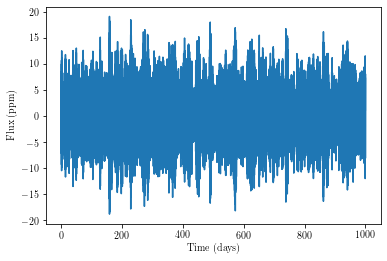

In [4]:
dt = 29.4*60
t = np.arange(0, 1000*86400, dt)
nyq = 1.0 / (2*dt)
bw = 1.0 / t[-1]
t = (t/86400.0) * u.day

params = [10.0, 100.0, 1.0]
white = 1.0
kernel, gp, S0 = compute_mode(params, white=white)
gp.compute(t.value)
# model from Kallinger (2014)
y = gp.sample()

plt.plot(t, y);
plt.xlabel('Time (days)');
plt.ylabel('Flux (ppm)');

In [5]:
y = y*cds.ppm
print(y)
lc = lk.LightCurve(time=t, flux=y)

# Approximate Nyquist Frequency and frequency bin width in terms of days
nyquist = 0.5 * (1./(np.median(np.diff(lc.time))))

ps = lc.to_periodogram(normalization='psd',
                       freq_unit=u.microhertz)

[ 1.69364654  1.49059157  3.34790444 ...  1.85742608 -1.39003959
 -7.99266412] ppm


The PSD of the stochastic SHO is given by Eqn (20) from [DFM (2017)](https://arxiv.org/pdf/1703.09710.pdf)

$$
S(\omega) = 4\sqrt{\frac{2}{\pi}}\frac{S_{0}\omega_{0}^{4}}{(\omega^{2}-\omega_{0}^{2})^{2} + \omega_{0}^{2}\omega^{2}/Q^{2}},
$$

where $S_{0}$ is proportional to the power at $\omega=\omega_{0}$, $S(\omega_{0})=4\sqrt{2/\pi}S_{0}Q^{2}$. 

To get to our standard Lorentzian profile we can make the assumption that the oscillations have a high Q-factor and near the resonant frequency ($\nu\approx\nu_{0}$) we get (Eqn (7) of Anderson (1990))

$$
L(\nu) = \frac{(P_{T}/\pi)(\Gamma/2)}{(\nu_{0}-\nu)^2 + (\Gamma/2)^2},
$$

where $P_{T}$ is the integrated power of the mode. This can be simplified to give a more familiar expression

$$
L(\nu) = \frac{2P_{T}/\pi\Gamma}{1 + (2/\Gamma)^2(\nu_{0}-\nu)^2},
$$

where $P_{T}=A^{2}$, where $A$ is the mode amplitude.

We can directly equate the quantities from the two expressions by matching the values at $\omega=\omega_{0}$, i.e.

$$
4\sqrt{\frac{2}{\pi}}S_{0}Q^{2} = H,
$$

where $H$ is the height of the Lorentzian profile. Therefore we get $S_{0} \propto H/Q^{2}$.

In [6]:
f = np.arange(bw, nyq, bw) * 1e6
lor = compute_lor_model(f, params, dt, white=white)
full = compute_full_model(f, params, dt, white=white)

In [7]:
psd = kernel.get_psd(2*np.pi*f*(86400.0/1e6))# / (2 * np.pi)
print(t.max())
# Get back into correct units
psd *= (2 / (t.max().value))
psd *= (2 / (f[1]-f[0]))

999.9879166666667 d


0.9977907910428081


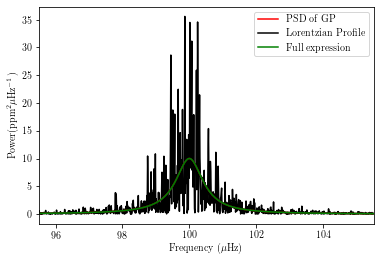

In [69]:
plt.plot(ps.frequency, ps.power, color='k')
# Have to add in white noise component to psd as celerite doesn't do
# it by default 
plt.plot(f, psd + 2e-6*white**2*dt, color='r', label=r'PSD of GP')
print(np.sum(lor)/np.sum(psd + 2e-6*white**2*dt))
plt.plot(f, lor, color='k', label=r'Lorentzian Profile')
plt.plot(f, full, color='g', label=r'Full expression')
#plt.xlim(params[1] - 10*params[2], params[1] + 10*params[2])
plt.xlim(95.5, 105.5)
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel(r'Power(ppm$^{2}\mu$Hz$^{-1}$)')
plt.legend(loc='best')
#plt.plot(f*1e6, backg_model)

Text(0, 0.5, 'Power Difference of analytical functions (ppm$^{2}\\mu$Hz$^{-1}$)')

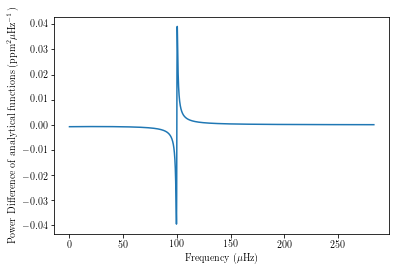

In [72]:
plt.plot(f, (lor) - full)
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel(r'Power Difference of analytical functions (ppm$^{2}\mu$Hz$^{-1}$)')
#plt.xlim(params[1] - 10*params[2], params[1] + 10*params[2])